# Visualizations Aggregates Fallecidos

## Content
- [Paths](#Paths)
- [Load data](#Load-data)
- [Life Expectancy oldest](#Life-Expectancy-oldest)
- [Life-expectancy-by-Estrato-main-20-cities](#Life-expectancy-by-Estrato-main-20-cities)
- [Life expectancy distribution by gender](#Life-expectancy-distribution-by-gender)

## Goal of visualization
- Show main visualitazions from aggregate data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import requests
import matplotlib
import re
from sodapy import Socrata
import configparser
import boto3
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2

In [2]:
os.chdir(os.path.join(os.getcwd(), ".."))

In [3]:
from src.config import metadata
from src.utils.s3_utils import (get_censo_paths, download_files_from_s3, read_multiple_csv,
                                mk_partitioned_dir, identified_partitioned_dir)
from src.utils.general_utils import create_dir

## Paths

In [4]:
config = configparser.ConfigParser()
config.read('aws.cfg')
aws = config["AWS"]
bucket = "censo-covid"
s3 = boto3.resource('s3',
                    region_name="us-west-2",
                    aws_access_key_id=aws['AWS_ACCESS_KEY_ID'],
                    aws_secret_access_key=aws['AWS_SECRET_ACCESS_KEY'])
s3_client = boto3.client('s3',
                         aws_access_key_id=aws['AWS_ACCESS_KEY_ID'],
                         aws_secret_access_key=aws['AWS_SECRET_ACCESS_KEY']
                        )

# Local paths
data_path = os.path.join(os.getcwd(), "data")
censo_data_path = os.path.join(data_path, "censo")
covid_path = os.path.join(os.getcwd(), "data", "covid.csv")
divipola_path = os.path.join(os.getcwd(), "data", "divipola.csv")
#complete_fallecidos_path = os.path.join(data_path, "complete_fallecidos") # Heavy downloads
#complete_personas_path = os.path.join(data_path, "complete_fallecidos") # Really heavy download
aggregates_path = os.path.join(data_path,'aggregates')
aggregates_personas_path = os.path.join(aggregates_path, 'personas')
aggregates_fallecidos_path = os.path.join(aggregates_path, 'fallecidos')
aggregates_covid_path = os.path.join(aggregates_path, 'covid')
joins_path = os.path.join(data_path,'joins')
joins_personas_path = os.path.join(joins_path, 'personas')
joins_fallecidos_path = os.path.join(data_path,'fallecidos')

# S3 paths
censo_covid_bucket_s3 = f"s3a://{bucket}"

raw_data_path_s3 = os.path.join(censo_covid_bucket_s3, "raw-data")
censo_data_path_s3 = os.path.join(raw_data_path_s3, "censo")
covid_tests_path_s3 = os.path.join(raw_data_path_s3, "covid-tests.csv")
covid_path_s3 = os.path.join(raw_data_path_s3, "covid.csv")
divipola_path_s3 = os.path.join(raw_data_path_s3, "divipola.csv")

final_data_path_s3 = os.path.join(censo_covid_bucket_s3, "final-data")
#complete_personas_path = os.path.join(final_data_path, "complete_personas")# Heavy downloads
#complete_fallecidos_path = os.path.join(final_data_path, "complete_fallecidos")# Really heavy download

aggregates_personas_path_s3 = os.path.join(final_data_path_s3, "aggregates_personas")
aggregates_fallecidos_path_s3 = os.path.join(final_data_path_s3, "aggregates_fallecidos")
aggregates_covid_path_s3 = os.path.join(final_data_path_s3, "aggregates_covid")

join_personas_covid_path_s3 = os.path.join(final_data_path_s3, "join_personas_covid")
join_fallecidos_covid_path_s3 = os.path.join(final_data_path_s3, "join_fallecidos_covid")

s3Bucket = s3.Bucket(bucket)

# Load data

In [5]:
create_dir(aggregates_fallecidos_path)

/Users/camilovelasquez/Desktop/Documents/Camilo/Udacity/censo_covid_colombia/data/aggregates/fallecidos dir exists


In [6]:
download_files_from_s3(aggregates_fallecidos_path, s3Bucket,
                       prefix=aggregates_fallecidos_path_s3.replace(censo_covid_bucket_s3 + "/", ""))

Already downloaded final-data/aggregates_fallecidos


In [7]:
to_concat, list_files = read_multiple_csv(aggregates_fallecidos_path, to_concat=[],
                                          list_of_files=[], header=0, n_files=10)

In [8]:
df = pd.concat(to_concat)
df.head()

,nom_mpio,Number_of_people_fallecidos,Number_of_dead_males,Number_of_dead_females,Avg_Age_w_0s,Avg_Death_Age,Avg_Death_Age_Male,Avg_Death_Age_Female,Avg_Death_Age_Estrato1,Avg_Death_Age_Estrato2,Avg_Death_Age_Estrato3,Avg_Death_Age_Estrato4,Avg_Death_Age_Estrato5,Avg_Death_Age_Estrato6,Number_of_dead_Estrato1,Number_of_dead_Estrato2,Number_of_dead_Estrato3,Number_of_dead_Estrato4,Number_of_dead_Estrato5,Number_of_dead_Estrato6,Avg_Death_Age_Cabecera,Avg_Death_Age_Centro_Poblado,Avg_Death_Age_Rural_Disperso,Avg_Death_Age_Resto_Rural,Number_of_dead_Cabecera,Number_of_dead_Centro_Poblado,Number_of_dead_Rural_Disperso,Number_of_dead_Resto_Rural,dpto
0,PAIPA,171,100.0,70.0,72.251462,77.675159,71.623656,71.984127,66.971429,82.336634,72.888889,89.0,NaN,NaN,38.0,110.0,19.0,3.0,NaN,NaN,85.010870,NaN,NaN,67.292308,102.0,NaN,NaN,69.0,BOYACÁ
1,CHITA,110,49.0,61.0,71.381818,81.851064,69.711111,93.000000,90.068966,68.000000,NaN,NaN,NaN,NaN,66.0,29.0,NaN,NaN,NaN,NaN,68.782609,NaN,NaN,86.084507,30.0,NaN,NaN,80.0,BOYACÁ
2,NOBSA,101,47.0,54.0,63.554455,70.056180,71.950000,68.510204,77.000000,69.635294,85.000000,NaN,NaN,NaN,4.0,96.0,1.0,NaN,NaN,NaN,71.740741,NaN,NaN,69.322581,33.0,NaN,NaN,68.0,BOYACÁ
3,TURMEQUÉ,54,32.0,22.0,64.203704,70.061224,67.428571,73.571429,73.250000,69.227273,NaN,NaN,NaN,NaN,4.0,49.0,NaN,NaN,NaN,NaN,64.000000,NaN,NaN,72.485714,17.0,NaN,NaN,37.0,BOYACÁ
4,SOCOTÁ,54,23.0,31.0,68.981481,73.500000,64.772727,80.357143,70.000000,77.040000,69.000000,NaN,NaN,NaN,26.0,26.0,1.0,NaN,NaN,NaN,78.200000,NaN,NaN,72.977778,5.0,NaN,NaN,49.0,BOYACÁ


### Life Expectancy oldest

In [9]:
print("Life expectancy (More than 200 deaths in 2017)")
df.loc[df["Number_of_people_fallecidos"]>200,
       ["dpto", "nom_mpio", "Avg_Death_Age", "Number_of_people_fallecidos"]]\
        .sort_values("Avg_Death_Age", ascending=False)[:15]

Life expectancy (More than 200 deaths in 2017)


,dpto,nom_mpio,Avg_Death_Age,Number_of_people_fallecidos
78,BOYACÁ,SOGAMOSO,78.201869,610
40,ANTIOQUIA,GIRARDOTA,76.996109,280
88,ANTIOQUIA,ENVIGADO,76.959947,863
53,ANTIOQUIA,COPACABANA,75.469496,439
55,ANTIOQUIA,SABANETA,75.276056,391
49,BOYACÁ,PUERTO BOYACÁ,74.968326,280
16,ATLÁNTICO,BARRANQUILLA,74.552985,4172
5,CALDAS,RIOSUCIO,74.446701,433
59,ANTIOQUIA,BARBOSA,74.274678,294
77,BOYACÁ,DUITAMA,74.250000,656


### Life expectancy by Estrato main 20 cities

In [10]:
estrato_cols = [col for col in df.columns if "Avg_Death_Age_Estrato" in col]
look_up_cols = ["dpto", "nom_mpio", "Number_of_people_fallecidos"] + estrato_cols
aux = df[look_up_cols].sort_values("Number_of_people_fallecidos", ascending=False)[:20]
aux = aux.drop(columns=["Number_of_people_fallecidos"]).set_index(["dpto", "nom_mpio"]).stack().to_frame().reset_index()
aux.columns = ["dpto", "nom_mpio", "Estrato", "Life Expectancy"]
aux["Estrato"] = aux["Estrato"].str[-8:]

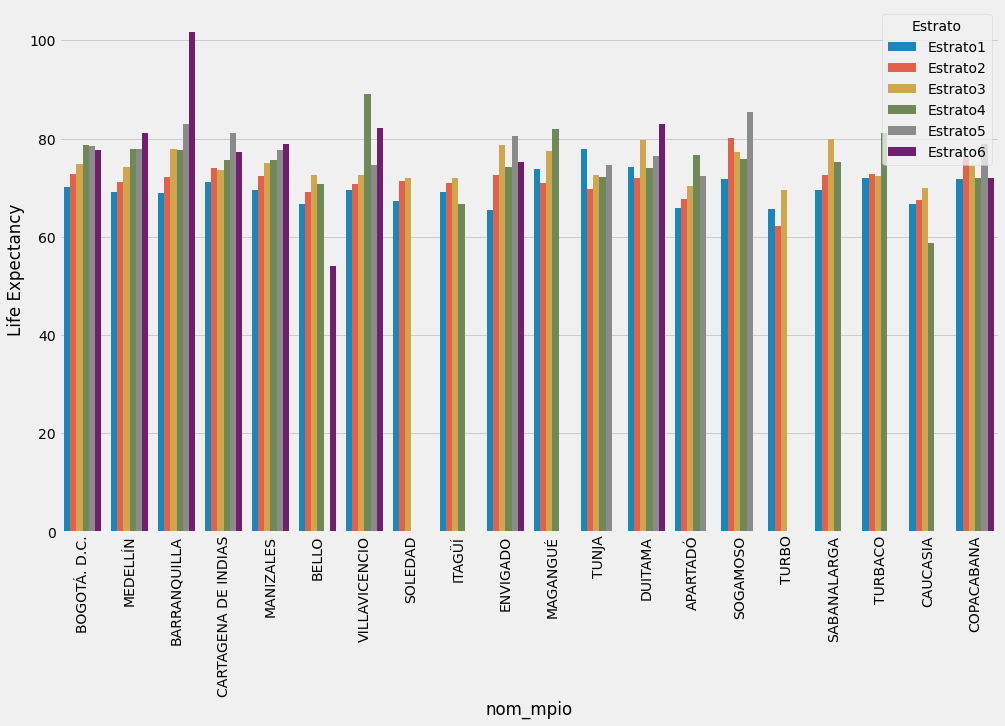

In [11]:
fig, ax = plt.subplots(figsize=(15,9))
ax = sns.barplot(data=aux, x="nom_mpio", y="Life Expectancy", hue="Estrato", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Life expectancy distribution by gender

In [12]:
look_up_cols = ["dpto", "nom_mpio", "Number_of_people_fallecidos"] + ['Avg_Death_Age_Male', 'Avg_Death_Age_Female']
aux = df[look_up_cols].sort_values("Number_of_people_fallecidos", ascending=False)[:60]
aux = aux.drop(columns=["Number_of_people_fallecidos"]).set_index(["dpto", 
                                                                   "nom_mpio"]).stack().to_frame().reset_index()
aux.columns = ["dpto", "nom_mpio", "Gender", "Life Expectancy"]
aux["Gender"] = aux["Gender"].str.split("_").str[-1]

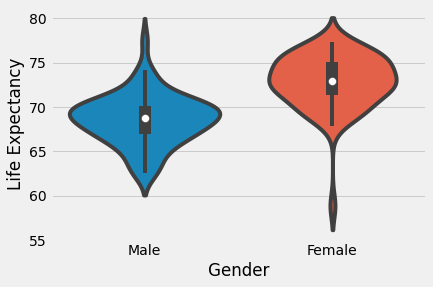

In [13]:
sns.violinplot(data=aux, x="Gender", y="Life Expectancy")
plt.show()